In [ ]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import math

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load in Data and First Time Step

In [ ]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                              },
                          }
    )
sim.setup()

In [3]:
pop0 = sim.get_population()
pop0.head()

,tracked,sex,age,exit_time,location,alive,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,sbp_multiplier,ldlc_medication_adherence,lifestyle,ldlc_medication,lifestyle_adherence,ldlc_therapeutic_inertia_propensity,sbp_medication,visit_type,scheduled_date,last_fpg_test_date
0,True,Female,47.388882,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,1.051,cat3,NaT,no_treatment,True,0.717433,one_drug_half_dose_efficacy,none,NaT,NaT
1,True,Male,41.564194,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,1.000,cat3,NaT,no_treatment,False,0.605149,no_treatment,none,NaT,NaT
2,True,Female,53.155826,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,1.000,cat3,NaT,no_treatment,False,0.860329,no_treatment,none,NaT,NaT
3,True,Male,30.457692,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,1.000,cat1,NaT,no_treatment,True,0.917036,no_treatment,none,NaT,NaT
4,True,Female,19.554806,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,1.000,cat3,NaT,no_treatment,False,0.776583,no_treatment,none,NaT,NaT


In [4]:
#pop0.columns

In [5]:
#sim.list_values()

In [6]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('categorical_high_systolic_blood_pressure.exposure')(pop0.index).rename('cat_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('heart_failure_from_ischemic_heart_disease.incidence_rate')(pop0.index).rename('hf_ihd'),
                   sim.get_value('heart_failure_residual.incidence_rate')(pop0.index).rename('hf_resid'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke'),
                  ], axis=1)
data1.head()

,tracked,sex,age,exit_time,location,alive,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,last_fpg_test_date,high_ldl,high_sbp,cat_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,stroke
0,True,Female,47.388882,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,NaT,2.125019,138.926833,cat2,23.052512,7.655254,0.000027,0.000072,0.000036,0.000011
1,True,Male,41.564194,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,NaT,2.397553,137.634343,cat2,23.897422,9.447039,0.000018,0.000051,0.000117,0.000009
2,True,Female,53.155826,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,NaT,2.110561,139.700114,cat2,22.755900,8.609653,0.000058,0.000106,0.000055,0.000035
3,True,Male,30.457692,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,NaT,2.133673,127.697819,cat3,23.783141,8.511144,0.000014,0.000062,0.000040,0.000004
4,True,Female,19.554806,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,NaT,0.000000,50.000000,cat4,5.000000,1.000000,0.000001,0.000024,0.000008,0.000006


In [7]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

In [8]:
data1.head()

,tracked,sex,age,exit_time,location,alive,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl,high_sbp,cat_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,stroke,age_start
0,True,Female,47.388882,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,2.125019,138.926833,cat2,23.052512,7.655254,0.000027,0.000072,0.000036,0.000011,45.0
1,True,Male,41.564194,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,2.397553,137.634343,cat2,23.897422,9.447039,0.000018,0.000051,0.000117,0.000009,40.0
2,True,Female,53.155826,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,2.110561,139.700114,cat2,22.755900,8.609653,0.000058,0.000106,0.000055,0.000035,50.0
3,True,Male,30.457692,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,2.133673,127.697819,cat3,23.783141,8.511144,0.000014,0.000062,0.000040,0.000004,30.0
6,True,Male,28.652525,NaT,Alabama,alive,2020-12-04,not_dead,0.0,0.0,...,3.286407,129.540010,cat3,36.145501,5.442680,0.000013,0.000086,0.000076,0.000004,25.0


# Relative Risk Regression Graphs 

In [9]:
## TMRELs for all risks

tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

In [10]:
#Create the dataset needed to run the regression model

data_regression = data1[['age_start','sex','high_ldl','high_sbp','high_bmi','cat_sbp','high_fpg','acute_mi','stroke','hf_ihd','hf_resid']]
data_regression['sbp_exposure'] = np.where(data_regression.high_sbp < tmrel_sbp, 0, (data_regression.high_sbp - tmrel_sbp)/10)
data_regression['ldl_exposure'] = np.where(data_regression.high_ldl < tmrel_ldl, 0, (data_regression.high_ldl - tmrel_ldl))
data_regression['bmi_exposure'] = np.where(data_regression.high_bmi < tmrel_bmi, 0, (data_regression.high_bmi - tmrel_bmi)/5)
data_regression['fpg_exposure'] = np.where(data_regression.high_fpg < tmrel_fpg, 0, (data_regression.high_fpg - tmrel_fpg))
data_regression = data_regression.loc[data_regression.age_start < 100]
data_regression.head()

,age_start,sex,high_ldl,high_sbp,high_bmi,cat_sbp,high_fpg,acute_mi,stroke,hf_ihd,hf_resid,sbp_exposure,ldl_exposure,bmi_exposure,fpg_exposure
0,45.0,Female,2.125019,138.926833,23.052512,cat2,7.655254,0.000036,0.000011,0.000027,0.000072,2.642683,1.125019,0.110502,2.555254
1,40.0,Male,2.397553,137.634343,23.897422,cat2,9.447039,0.000117,0.000009,0.000018,0.000051,2.513434,1.397553,0.279484,4.347039
2,50.0,Female,2.110561,139.700114,22.755900,cat2,8.609653,0.000055,0.000035,0.000058,0.000106,2.720011,1.110561,0.051180,3.509653
3,30.0,Male,2.133673,127.697819,23.783141,cat3,8.511144,0.000040,0.000004,0.000014,0.000062,1.519782,1.133673,0.256628,3.411144
6,25.0,Male,3.286407,129.540010,36.145501,cat3,5.442680,0.000076,0.000004,0.000013,0.000086,1.704001,2.286407,2.729100,0.342680


# Here we start running regressions to find relative risks

## Acute Myocardial Infarction

### LDL-C

In [11]:
## This is the regression between simulant level incidence values and exposure values

df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ ldl_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000208
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000220
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000146
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000323
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000495
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000128
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000390
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000342
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000223
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [12]:
df = df.loc[df.index=='ldl_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
ldl_exposure,25.0,Female,0.652911,1.921125
ldl_exposure,25.0,Male,0.859585,2.362181
ldl_exposure,30.0,Female,1.499368,4.478858
ldl_exposure,30.0,Male,0.521930,1.685278
ldl_exposure,35.0,Female,0.898929,2.456970


In [13]:
## Loading in artifact data to compare aganist

In [14]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [15]:
rel_risk = art.load('risk_factor.high_ldl_cholesterol.relative_risk')
ldl_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
ldl_rr_mi = ldl_rr.loc[ldl_rr['affected_entity']=='acute_myocardial_infarction']
ldl_rr_mi.head()

,affected_entity,age_start,sex,mean
30,acute_myocardial_infarction,25.0,Female,2.0053
31,acute_myocardial_infarction,25.0,Male,2.0053
32,acute_myocardial_infarction,30.0,Female,2.0267
33,acute_myocardial_infarction,30.0,Male,2.0267
34,acute_myocardial_infarction,35.0,Female,2.0483


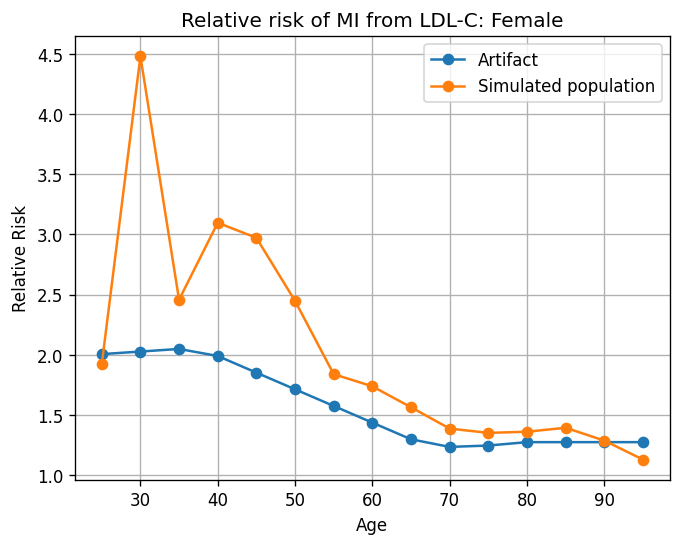

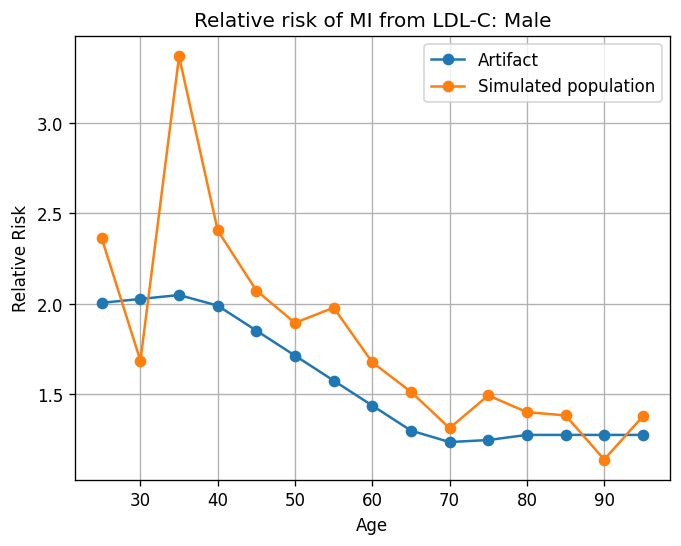

In [16]:
with PdfPages('MI_ldl_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = ldl_rr_mi.loc[ldl_rr_mi['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from LDL-C: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### SBP 

In [17]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ sbp_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000211
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000223
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000147
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000332
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000506
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000129
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000393
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000225
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [18]:
df = df.loc[df.index=='sbp_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
sbp_exposure,25.0,Female,1.163349,3.200635
sbp_exposure,25.0,Male,0.711231,2.036496
sbp_exposure,30.0,Female,1.141073,3.130124
sbp_exposure,30.0,Male,0.870220,2.387435
sbp_exposure,35.0,Female,0.785583,2.193685


In [19]:
rel_risk = art.load('risk_factor.high_systolic_blood_pressure.relative_risk')
mi_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
mi_rr = mi_rr.loc[mi_rr['affected_entity']=='acute_myocardial_infarction']
mi_rr.head()

,affected_entity,age_start,sex,mean
30,acute_myocardial_infarction,25.0,Female,2.0317
31,acute_myocardial_infarction,25.0,Male,2.0317
32,acute_myocardial_infarction,30.0,Female,1.8558
33,acute_myocardial_infarction,30.0,Male,1.8558
34,acute_myocardial_infarction,35.0,Female,1.6799


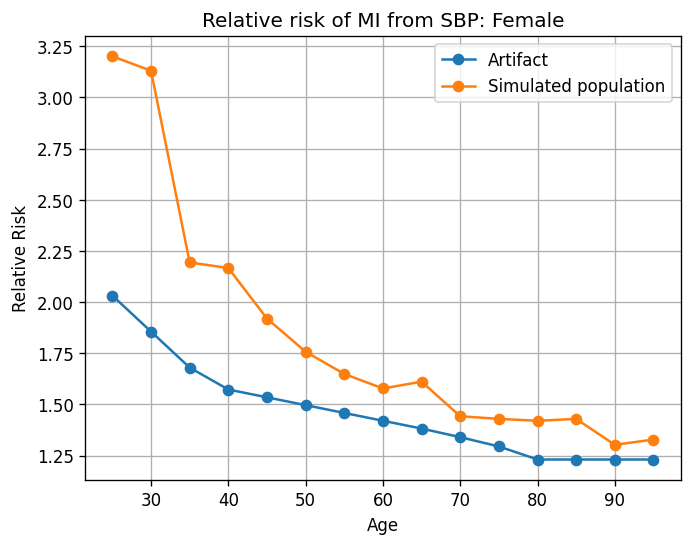

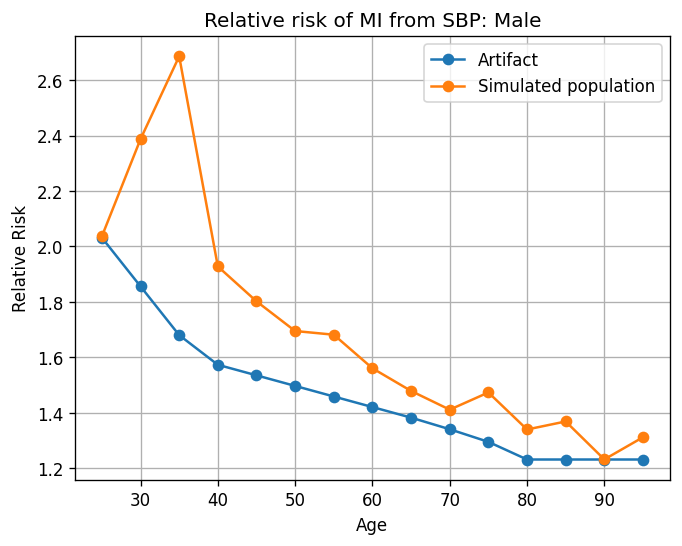

In [20]:
with PdfPages('MI_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = mi_rr.loc[mi_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from SBP: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### FPG

In [21]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ fpg_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000208
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000220
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000147
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000316
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000574
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000130
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000392
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000344
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000224
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [22]:
df = df.loc[df.index=='fpg_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
fpg_exposure,25.0,Female,1.043689,2.839674
fpg_exposure,25.0,Male,0.990249,2.691905
fpg_exposure,30.0,Female,0.849896,2.339405
fpg_exposure,30.0,Male,0.551940,1.736619
fpg_exposure,35.0,Female,0.482398,1.619954


In [23]:
rel_risk = art.load('risk_factor.high_fasting_plasma_glucose.relative_risk')
mi_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
mi_rr = mi_rr.loc[mi_rr['affected_entity']=='acute_myocardial_infarction']
mi_rr.head()

,affected_entity,age_start,sex,mean
30,acute_myocardial_infarction,25.0,Female,1.9325
31,acute_myocardial_infarction,25.0,Male,1.9325
32,acute_myocardial_infarction,30.0,Female,1.6915
33,acute_myocardial_infarction,30.0,Male,1.6915
34,acute_myocardial_infarction,35.0,Female,1.4505


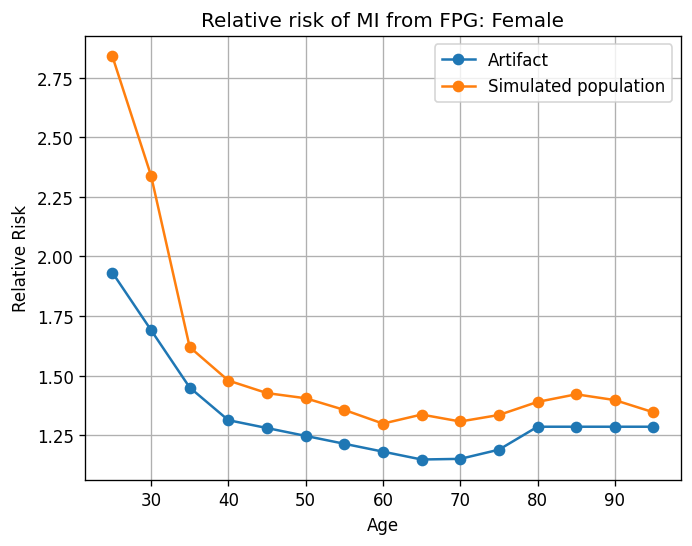

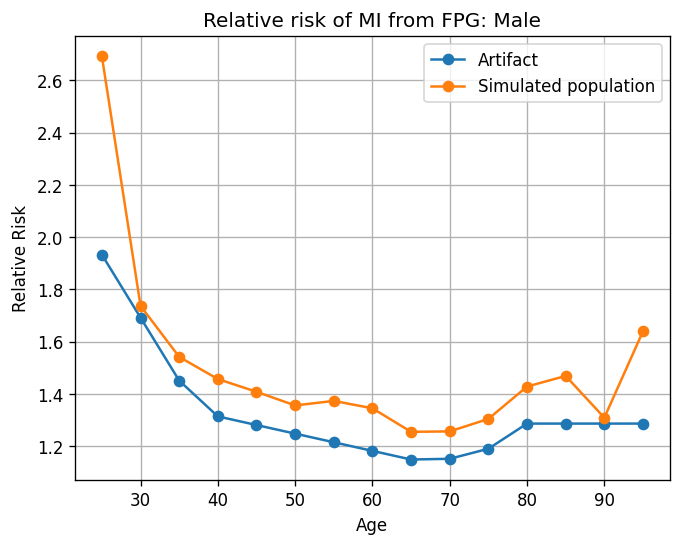

In [24]:
with PdfPages('MI_fpg_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = mi_rr.loc[mi_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from FPG: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### BMI

In [25]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("acute_mi ~ bmi_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000209
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000222
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000146
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000326
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000560
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000129
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000391
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000343
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000224
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [26]:
df = df.loc[df.index=='bmi_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
bmi_exposure,25.0,Female,1.649301,5.203340
bmi_exposure,25.0,Male,1.477962,4.384000
bmi_exposure,30.0,Female,1.142497,3.134586
bmi_exposure,30.0,Male,0.980302,2.665260
bmi_exposure,35.0,Female,0.803982,2.234421


In [27]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
mi_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
mi_rr = mi_rr.loc[mi_rr['affected_entity']=='acute_myocardial_infarction']
mi_rr.head()

,affected_entity,age_start,sex,mean
30,acute_myocardial_infarction,25.0,Female,3.510608
31,acute_myocardial_infarction,25.0,Male,3.510608
32,acute_myocardial_infarction,30.0,Female,2.094858
33,acute_myocardial_infarction,30.0,Male,2.094858
34,acute_myocardial_infarction,35.0,Female,1.685112


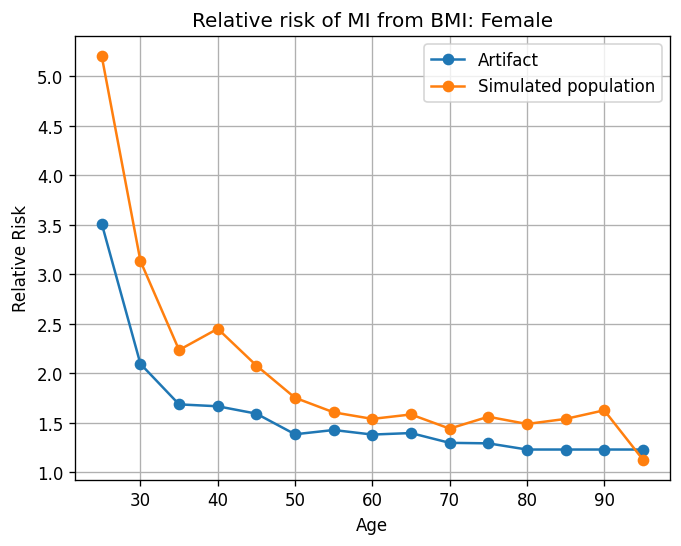

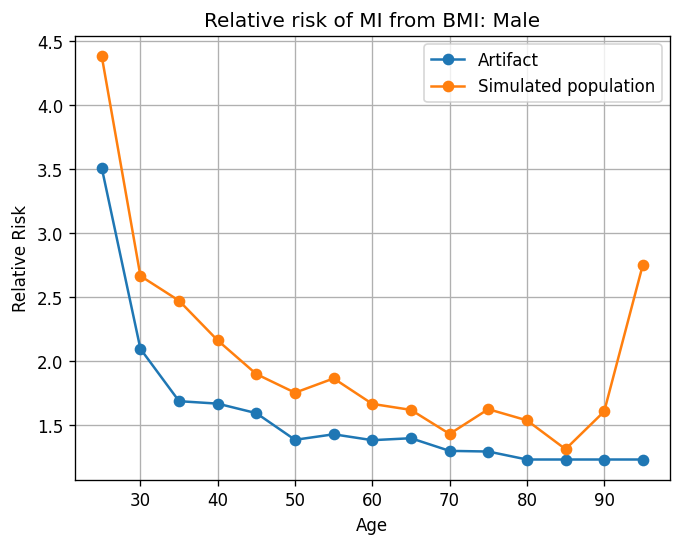

In [28]:
with PdfPages('MI_bmi_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = mi_rr.loc[mi_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of MI from BMI: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

## Stroke 

### LDL-C

In [29]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("stroke ~ ldl_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000073
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000185
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000133
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000143
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [30]:
df = df.loc[df.index=='ldl_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
ldl_exposure,25.0,Female,0.506370,1.659257
ldl_exposure,25.0,Male,0.524789,1.690102
ldl_exposure,30.0,Female,1.017186,2.765402
ldl_exposure,30.0,Male,0.415327,1.514867
ldl_exposure,35.0,Female,0.682861,1.979532


In [31]:
rel_risk = art.load('risk_factor.high_ldl_cholesterol.relative_risk')
stroke_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
stroke_rr = stroke_rr.loc[stroke_rr['affected_entity']=='acute_ischemic_stroke']
stroke_rr.head()

,affected_entity,age_start,sex,mean
0,acute_ischemic_stroke,25.0,Female,1.4165
1,acute_ischemic_stroke,25.0,Male,1.4165
2,acute_ischemic_stroke,30.0,Female,1.4715
3,acute_ischemic_stroke,30.0,Male,1.4715
4,acute_ischemic_stroke,35.0,Female,1.5265


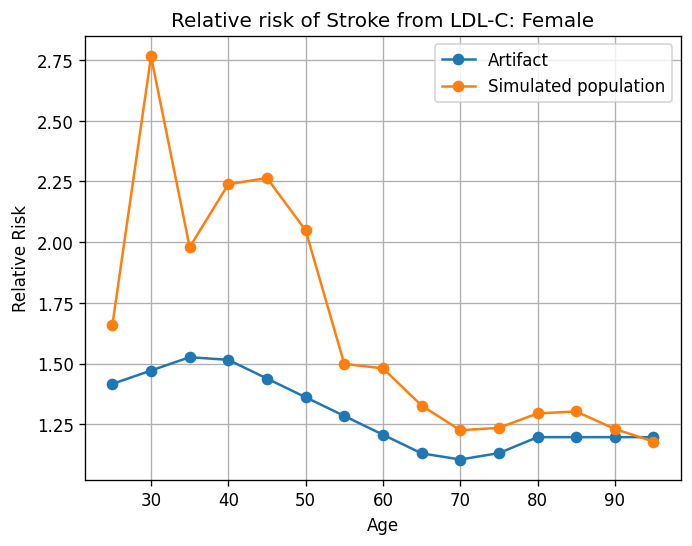

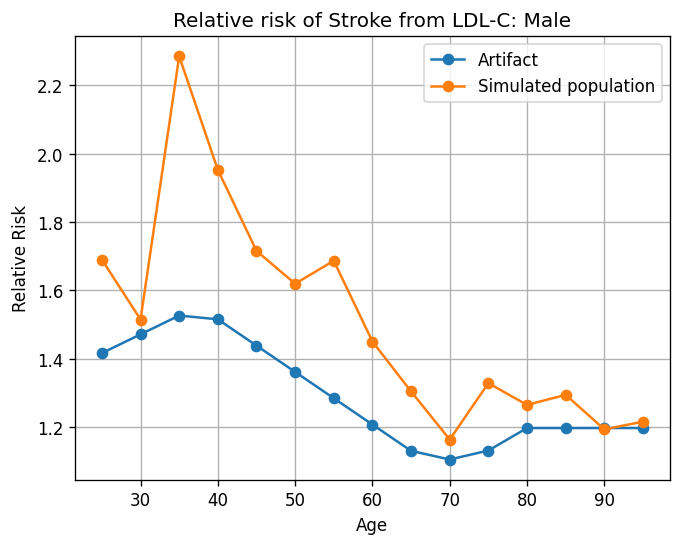

In [32]:
with PdfPages('stroke_ldl_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = stroke_rr.loc[stroke_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from LDL-C: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### SBP

In [33]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("stroke ~ sbp_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000073
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000162
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000186
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000133
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000143
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [34]:
df = df.loc[df.index=='sbp_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
sbp_exposure,25.0,Female,1.019296,2.771243
sbp_exposure,25.0,Male,0.645757,1.907430
sbp_exposure,30.0,Female,0.965846,2.627008
sbp_exposure,30.0,Male,0.792505,2.208922
sbp_exposure,35.0,Female,0.756414,2.130621


In [35]:
rel_risk = art.load('risk_factor.high_systolic_blood_pressure.relative_risk')
stroke_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
stroke_rr = stroke_rr.loc[stroke_rr['affected_entity']=='acute_ischemic_stroke']
stroke_rr.head()

,affected_entity,age_start,sex,mean
0,acute_ischemic_stroke,25.0,Female,1.7644
1,acute_ischemic_stroke,25.0,Male,1.7644
2,acute_ischemic_stroke,30.0,Female,1.7026
3,acute_ischemic_stroke,30.0,Male,1.7026
4,acute_ischemic_stroke,35.0,Female,1.6409


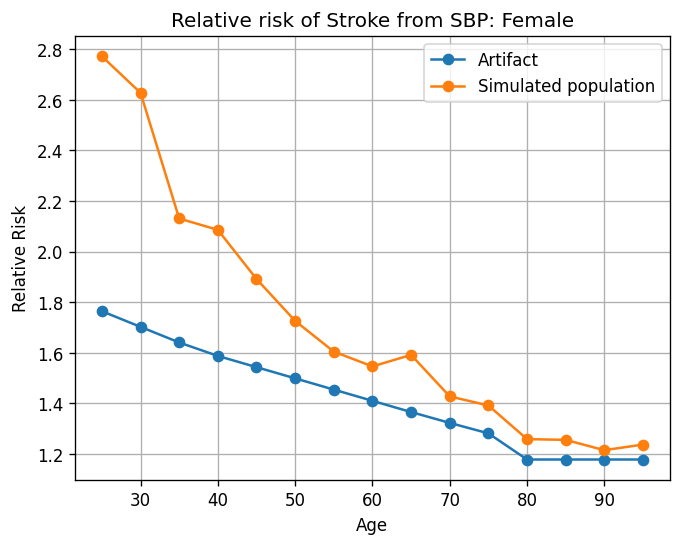

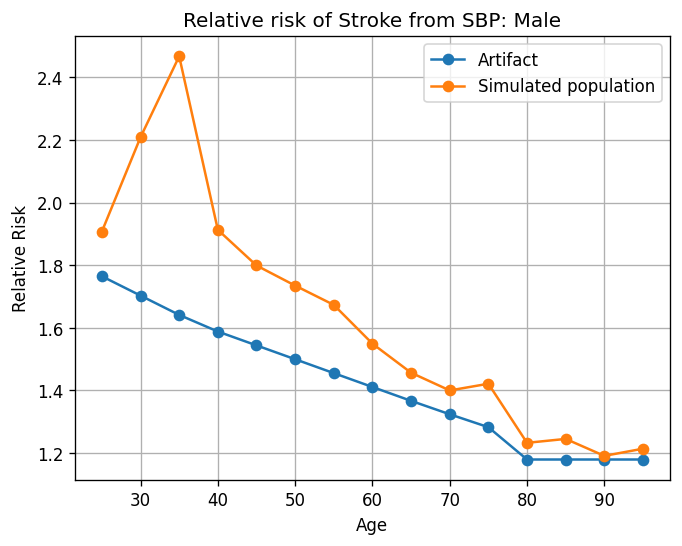

In [36]:
with PdfPages('stroke_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = stroke_rr.loc[stroke_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from SBP: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### FPG

In [37]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("stroke ~ fpg_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000073
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000186
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000133
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000143
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [38]:
df = df.loc[df.index=='fpg_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
fpg_exposure,25.0,Female,0.819576,2.269537
fpg_exposure,25.0,Male,0.958202,2.607004
fpg_exposure,30.0,Female,0.730618,2.076364
fpg_exposure,30.0,Male,0.472220,1.603550
fpg_exposure,35.0,Female,0.401902,1.494664


In [39]:
rel_risk = art.load('risk_factor.high_fasting_plasma_glucose.relative_risk')
stroke_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
stroke_rr = stroke_rr.loc[stroke_rr['affected_entity']=='acute_ischemic_stroke']
stroke_rr.head()

,affected_entity,age_start,sex,mean
0,acute_ischemic_stroke,25.0,Female,1.5236
1,acute_ischemic_stroke,25.0,Male,1.5236
2,acute_ischemic_stroke,30.0,Female,1.3974
3,acute_ischemic_stroke,30.0,Male,1.3974
4,acute_ischemic_stroke,35.0,Female,1.2711


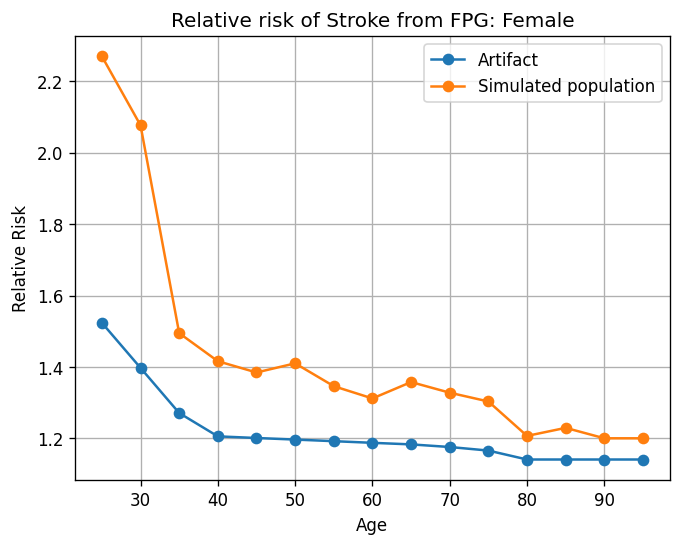

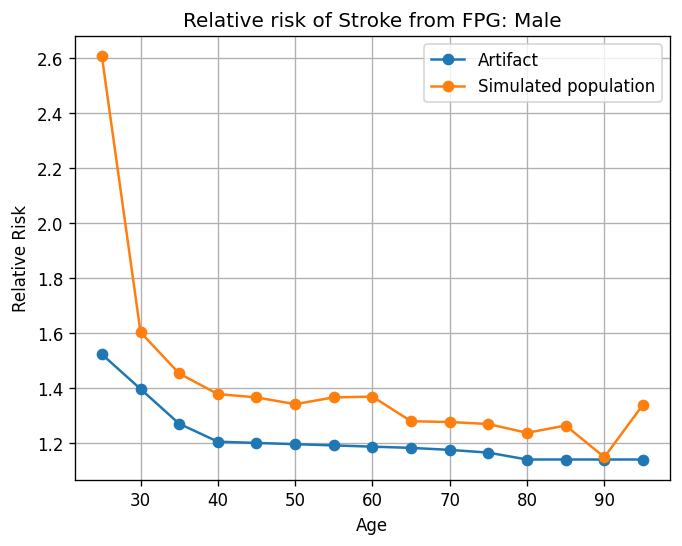

In [40]:
with PdfPages('stroke_fpg_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = stroke_rr.loc[stroke_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from FPG: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### BMI

In [41]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("stroke ~ bmi_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000073
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000162
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000035
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.000185
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000133
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000143
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [42]:
df = df.loc[df.index=='bmi_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
bmi_exposure,25.0,Female,1.105522,3.020802
bmi_exposure,25.0,Male,1.040808,2.831504
bmi_exposure,30.0,Female,1.037129,2.821106
bmi_exposure,30.0,Male,0.974623,2.650168
bmi_exposure,35.0,Female,0.872619,2.393170


In [43]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
stroke_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
stroke_rr = stroke_rr.loc[stroke_rr['affected_entity']=='acute_ischemic_stroke']
stroke_rr.head()

,affected_entity,age_start,sex,mean
0,acute_ischemic_stroke,25.0,Female,2.405075
1,acute_ischemic_stroke,25.0,Male,2.405075
2,acute_ischemic_stroke,30.0,Female,2.220086
3,acute_ischemic_stroke,30.0,Male,2.220086
4,acute_ischemic_stroke,35.0,Female,1.919950


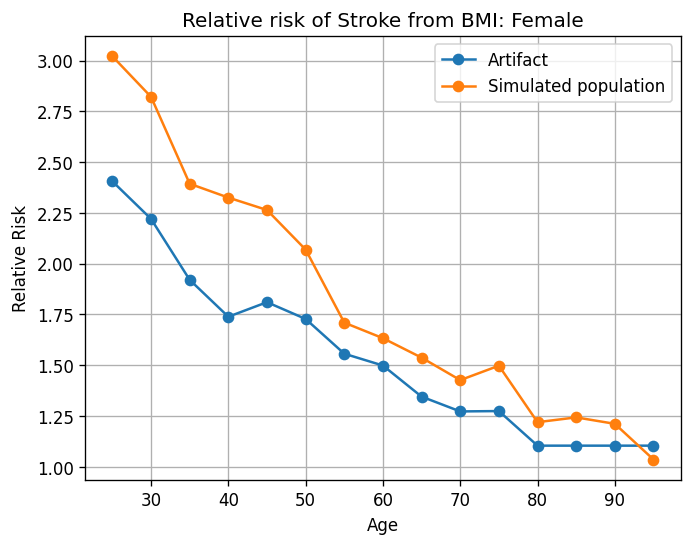

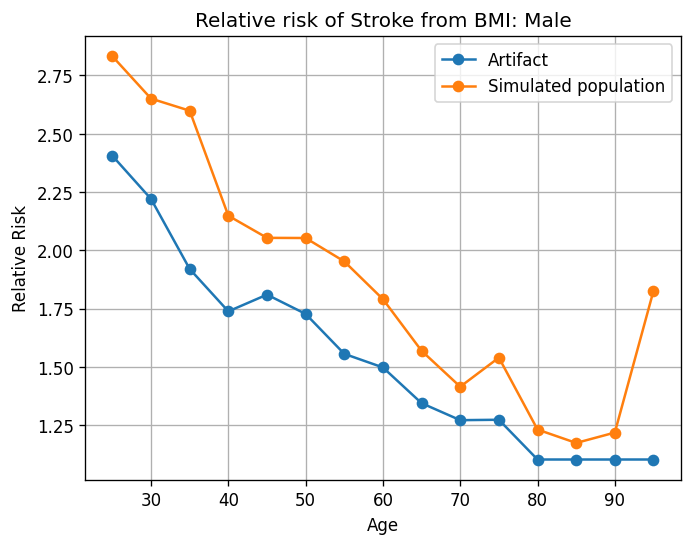

In [44]:
with PdfPages('stroke_bmi_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = stroke_rr.loc[stroke_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of Stroke from BMI: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

## Heart Failure 

### BMI

In [45]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("hf_resid ~ bmi_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000079
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000113
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000045
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000657
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.000168
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000257
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

In [46]:
df = df.loc[df.index=='bmi_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
bmi_exposure,25.0,Female,0.138829,1.148928
bmi_exposure,25.0,Male,0.146446,1.157712
bmi_exposure,30.0,Female,0.145348,1.156442
bmi_exposure,30.0,Male,0.154149,1.166665
bmi_exposure,35.0,Female,0.147580,1.159026


In [47]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
hf_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
hf_rr = hf_rr.loc[hf_rr['affected_entity']=='heart_failure_residual']
hf_rr.head()

,affected_entity,age_start,sex,mean
120,heart_failure_residual,25.0,Female,1.134219
121,heart_failure_residual,25.0,Male,1.134219
122,heart_failure_residual,30.0,Female,1.134219
123,heart_failure_residual,30.0,Male,1.134219
124,heart_failure_residual,35.0,Female,1.134219


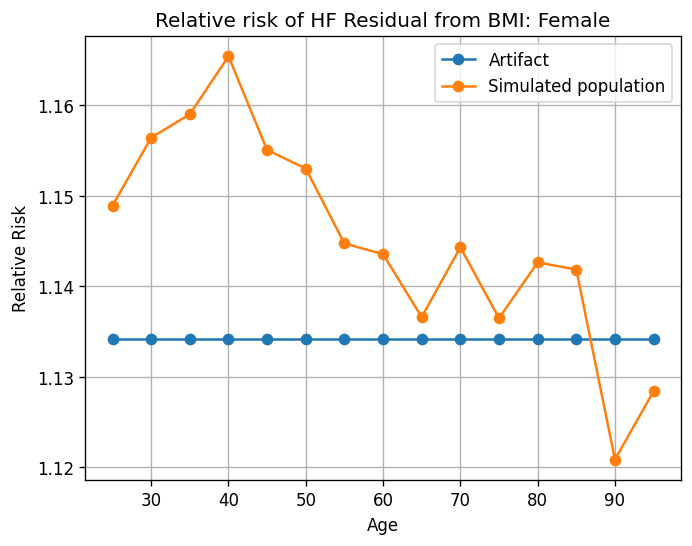

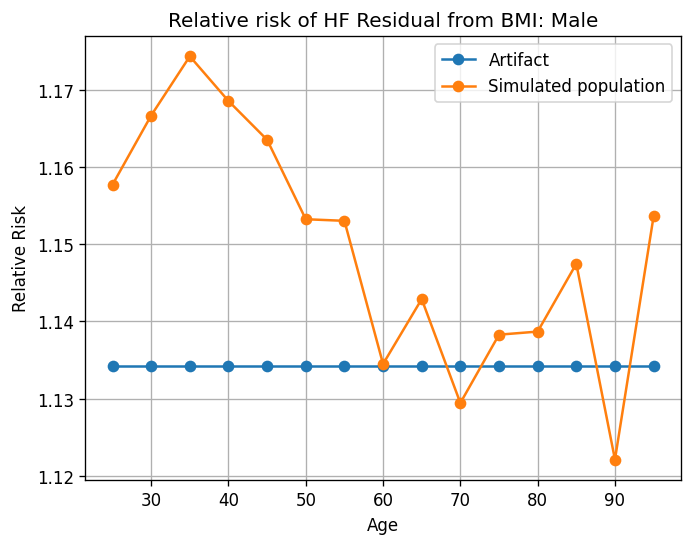

In [48]:
with PdfPages('hf_resid_bmi_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = hf_rr.loc[hf_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of HF Residual from BMI: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

In [49]:
df = pd.DataFrame() 
for sex in data_regression.sex.unique():
    for age in data_regression.age_start.unique():
        current_data = data_regression.loc[(data_regression['age_start']==age) & (data_regression['sex']==sex)]
        model = smf.logit("hf_ihd ~ bmi_exposure", data = current_data).fit()
        coeff = model.params
        results_df = pd.DataFrame({"age":age,
                               "sex":sex,
                               "coeff":coeff})
        df = df.append(results_df)

Optimization terminated successfully.
         Current function value: 0.000030
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.000553
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.000114
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.000217
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [50]:
df = df.loc[df.index=='bmi_exposure']
df['rr'] = np.exp(df.coeff)
df = df.sort_values(by=['age'])
df.head()

,age,sex,coeff,rr
bmi_exposure,25.0,Female,0.138822,1.148920
bmi_exposure,25.0,Male,0.146437,1.157702
bmi_exposure,30.0,Female,0.145341,1.156434
bmi_exposure,30.0,Male,0.154140,1.166654
bmi_exposure,35.0,Female,0.147577,1.159022


In [51]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
hf_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
hf_rr = hf_rr.loc[hf_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease']
hf_rr.head()

,affected_entity,age_start,sex,mean
90,heart_failure_from_ischemic_heart_disease,25.0,Female,1.134219
91,heart_failure_from_ischemic_heart_disease,25.0,Male,1.134219
92,heart_failure_from_ischemic_heart_disease,30.0,Female,1.134219
93,heart_failure_from_ischemic_heart_disease,30.0,Male,1.134219
94,heart_failure_from_ischemic_heart_disease,35.0,Female,1.134219


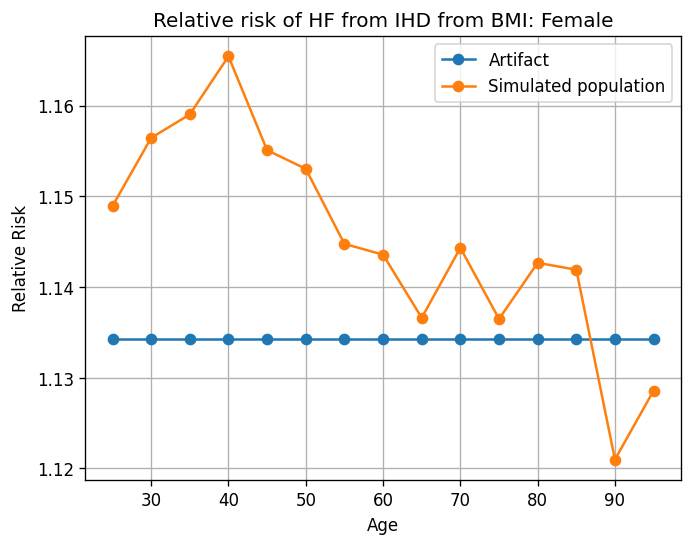

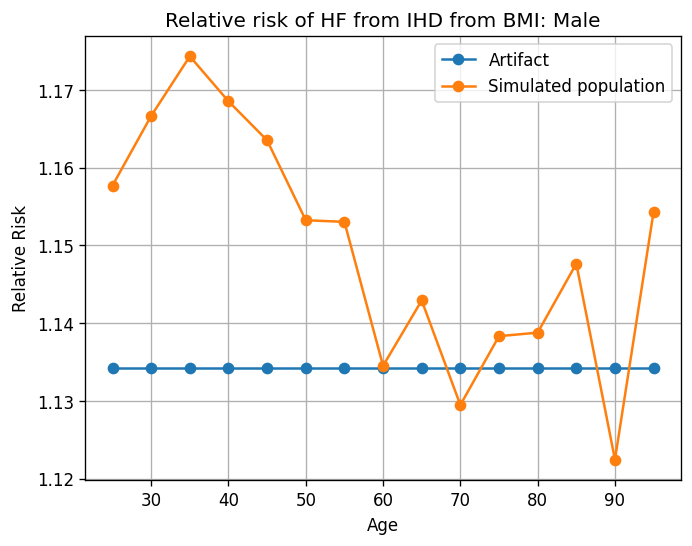

In [52]:
with PdfPages('hf_ihd_bmi_rr.pdf') as pdf:
    for sex in df.sex.unique():
        plt.figure(dpi=120)
        subdata = hf_rr.loc[hf_rr['sex']==sex]
        plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
        subdata2 = df.loc[df['sex']==sex]
        plt.plot(subdata2.age, subdata2.rr, marker='o', label='Simulated population')
        plt.title(f'Relative risk of HF from IHD from BMI: {sex}') 
        plt.ylabel('Relative Risk')
        plt.xlabel('Age')
        plt.legend()
        plt.grid()
        pdf.savefig(bbox_inches='tight')

### SBP (categorical)

In [53]:
df = pd.DataFrame() 
for age in data_regression.age_start.unique(): 
    for sex in data_regression.sex.unique():
        subdata1 = data_regression.loc[(data_regression.age_start == age) & (data_regression.sex == sex) & (data_regression.cat_sbp == 'cat4')] 
        mean_4 = subdata1.hf_ihd.mean()
        for cat in data_regression.cat_sbp.unique():
            rrs_temp = pd.DataFrame()
            subdata = data_regression.loc[(data_regression.age_start == age) & (data_regression.sex == sex) & (data_regression.cat_sbp == cat)] 
            mean = subdata.hf_ihd.mean()
            rr = mean/mean_4
            rrs_temp = pd.DataFrame({"age":age,
                             "sex": sex,
                               "Category":cat,
                               "RR":rr}, index=[1,2,3,4])
            df = df.append(rrs_temp)

In [54]:
df = df.sort_values(by=['age','Category'])
df.head()

,age,sex,Category,RR
1,25.0,Female,cat1,1.988082
2,25.0,Female,cat1,1.988082
3,25.0,Female,cat1,1.988082
4,25.0,Female,cat1,1.988082
1,25.0,Male,cat1,1.838887


In [55]:
rel_risk = art.load('risk_factor.categorical_high_systolic_blood_pressure.relative_risk')
hf_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex','parameter'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
hf_rr = hf_rr.loc[hf_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease']
hf_rr.head()

,affected_entity,age_start,sex,parameter,mean
0,heart_failure_from_ischemic_heart_disease,25.0,Female,cat1,1.645682
1,heart_failure_from_ischemic_heart_disease,25.0,Female,cat2,1.466387
2,heart_failure_from_ischemic_heart_disease,25.0,Female,cat3,1.219001
3,heart_failure_from_ischemic_heart_disease,25.0,Female,cat4,1.000000
4,heart_failure_from_ischemic_heart_disease,25.0,Male,cat1,1.645682


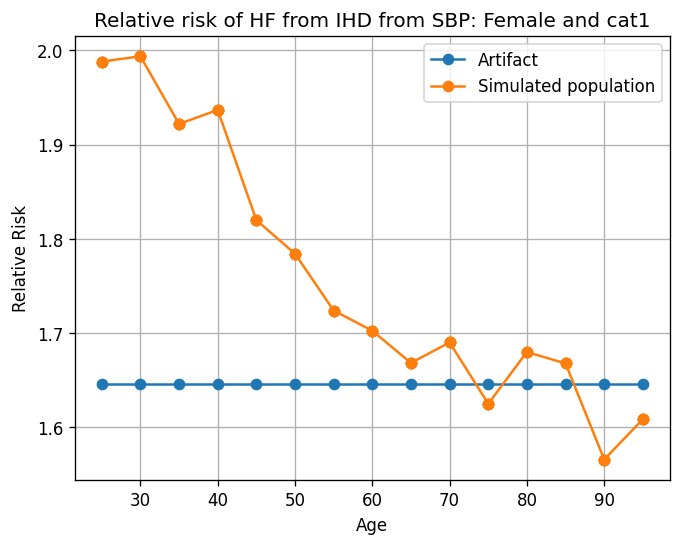

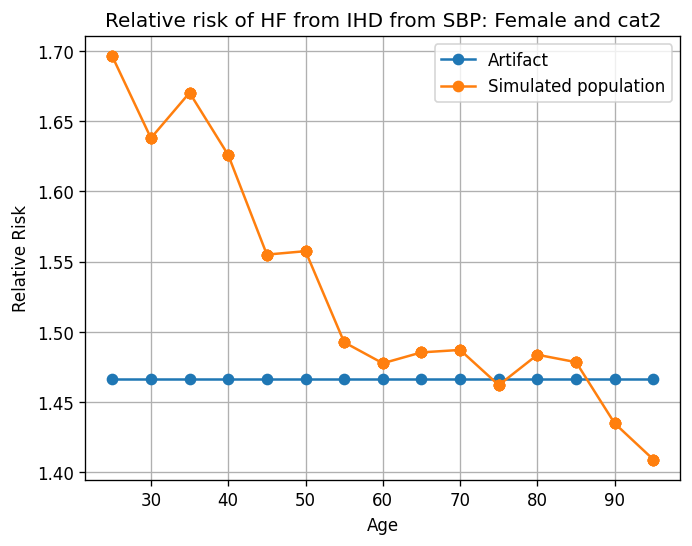

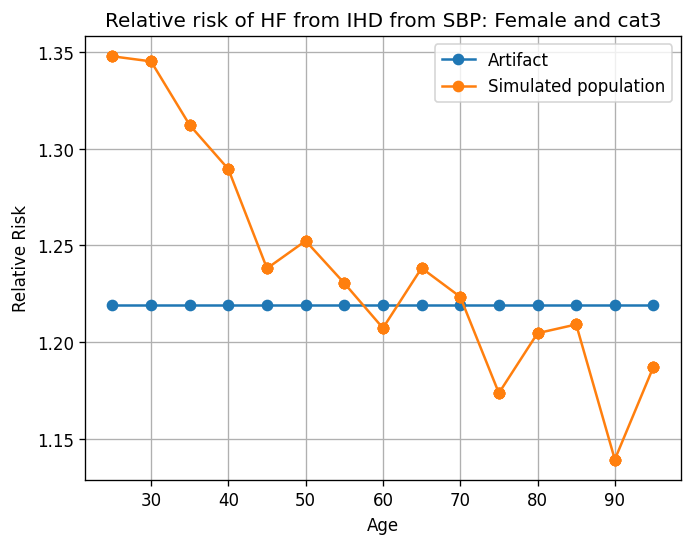

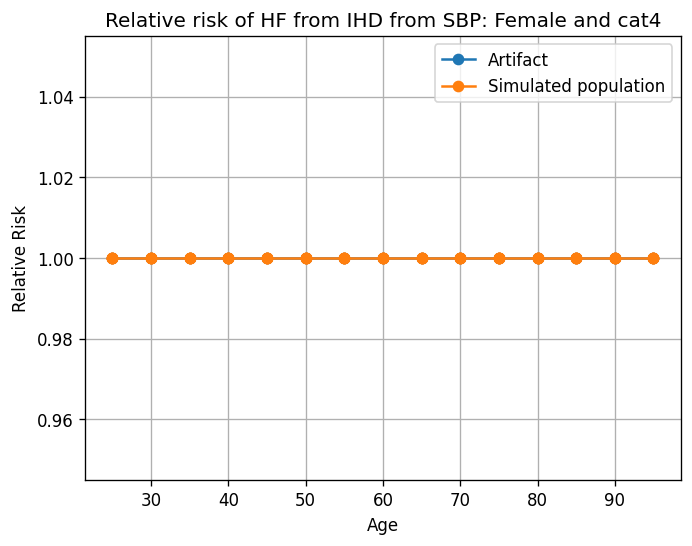

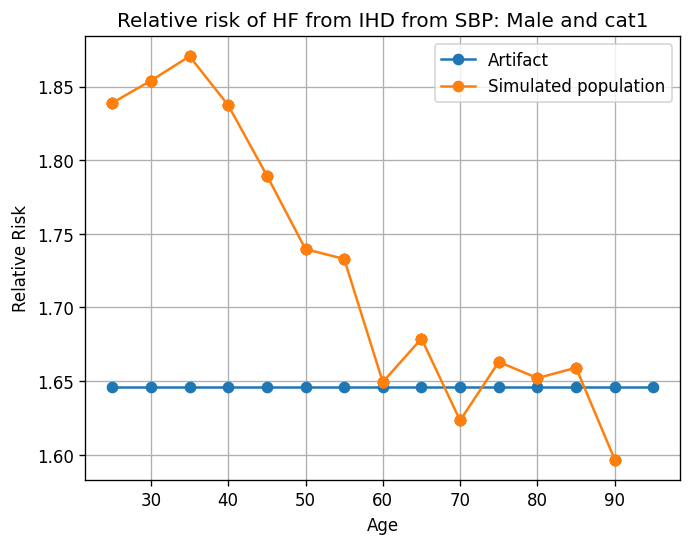

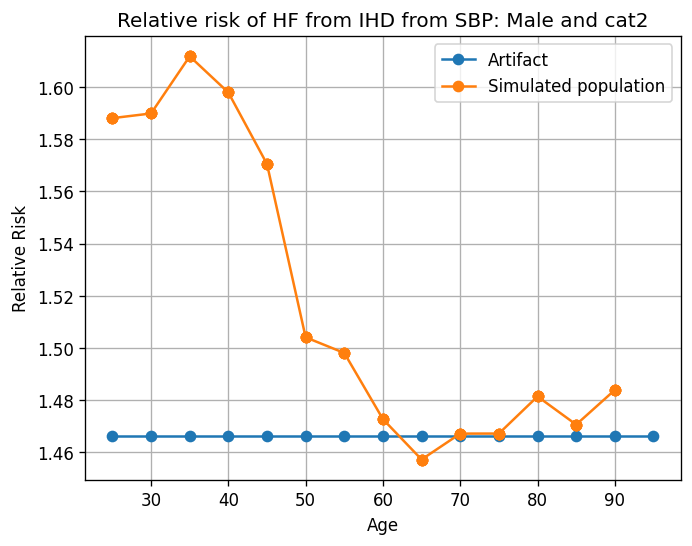

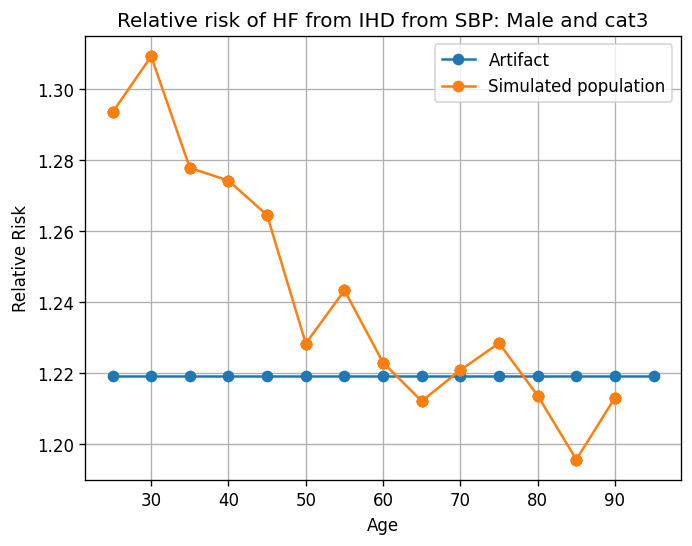

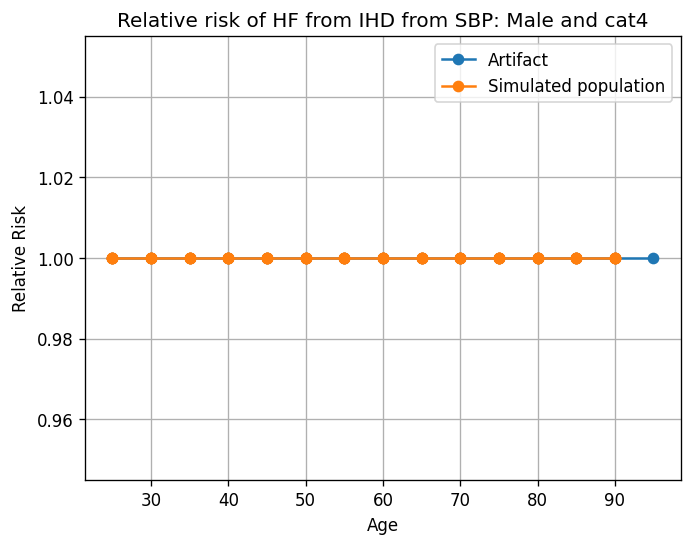

In [56]:
with PdfPages('hf_ihd_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        for cat in df.Category.unique():
            plt.figure(dpi=120)
            subdata = hf_rr.loc[(hf_rr['sex']==sex) & (hf_rr['parameter']==cat)]
            plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
            subdata2 = df.loc[(df['sex']==sex) & (df['Category']==cat)]
            plt.plot(subdata2.age, subdata2.RR, marker='o', label='Simulated population')
            plt.title(f'Relative risk of HF from IHD from SBP: {sex} and {cat}') 
            plt.ylabel('Relative Risk')
            plt.xlabel('Age')
            plt.legend()
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [57]:
df = pd.DataFrame() 
for age in data_regression.age_start.unique(): 
    for sex in data_regression.sex.unique():
        subdata1 = data_regression.loc[(data_regression.age_start == age) & (data_regression.sex == sex) & (data_regression.cat_sbp == 'cat4')] 
        mean_4 = subdata1.hf_resid.mean()
        for cat in data_regression.cat_sbp.unique():
            rrs_temp = pd.DataFrame()
            subdata = data_regression.loc[(data_regression.age_start == age) & (data_regression.sex == sex) & (data_regression.cat_sbp == cat)] 
            mean = subdata.hf_resid.mean()
            rr = mean/mean_4
            rrs_temp = pd.DataFrame({"age":age,
                             "sex": sex,
                               "Category":cat,
                               "RR":rr}, index=[1,2,3,4])
            df = df.append(rrs_temp)

In [58]:
df = df.sort_values(by=['age','Category'])
df.head()

,age,sex,Category,RR
1,25.0,Female,cat1,1.988082
2,25.0,Female,cat1,1.988082
3,25.0,Female,cat1,1.988082
4,25.0,Female,cat1,1.988082
1,25.0,Male,cat1,1.838887


In [59]:
rel_risk = art.load('risk_factor.categorical_high_systolic_blood_pressure.relative_risk')
hf_rr = (rel_risk
                .groupby(['affected_entity','age_start','sex','parameter'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
hf_rr = hf_rr.loc[hf_rr['affected_entity']=='heart_failure_residual']
hf_rr.head()

,affected_entity,age_start,sex,parameter,mean
120,heart_failure_residual,25.0,Female,cat1,1.645682
121,heart_failure_residual,25.0,Female,cat2,1.466387
122,heart_failure_residual,25.0,Female,cat3,1.219001
123,heart_failure_residual,25.0,Female,cat4,1.000000
124,heart_failure_residual,25.0,Male,cat1,1.645682


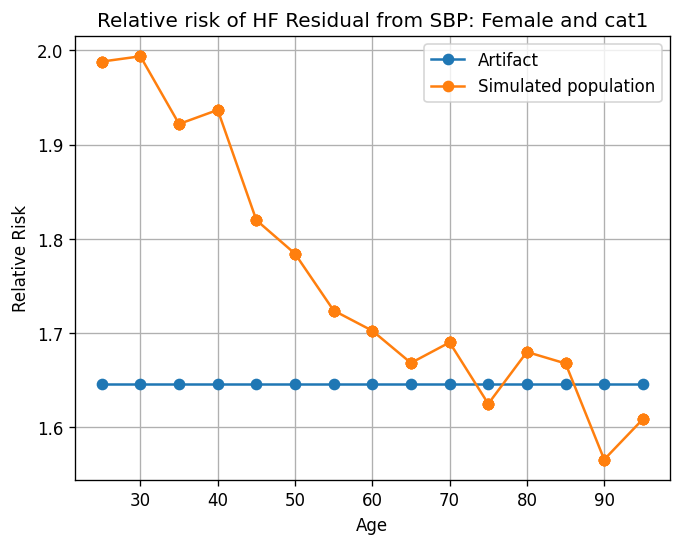

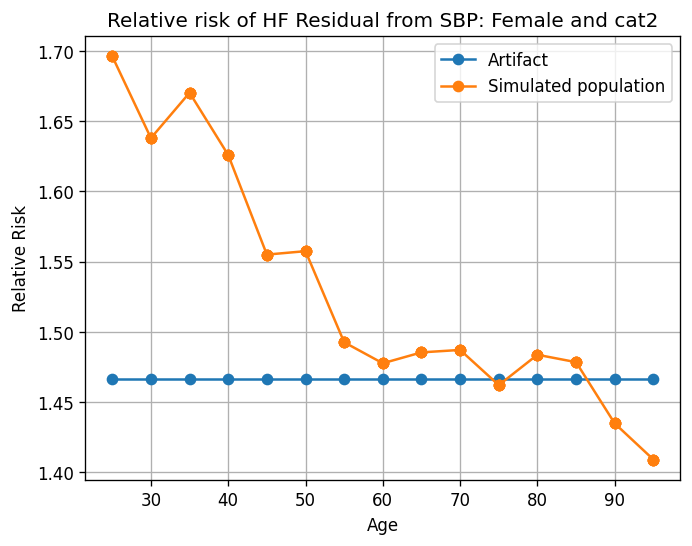

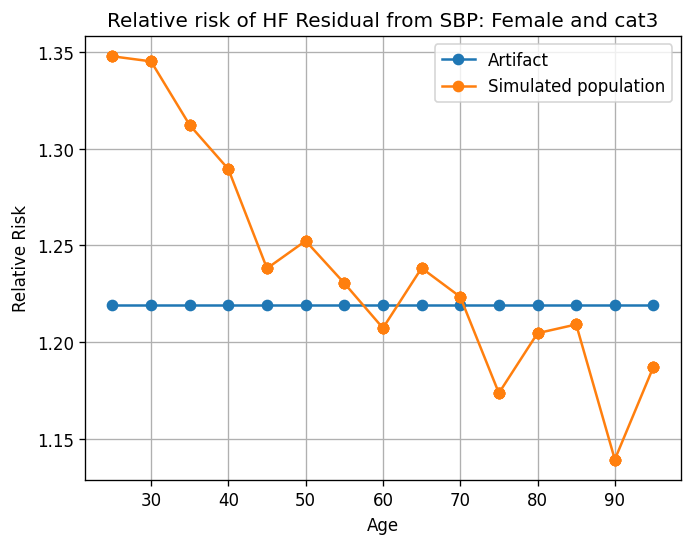

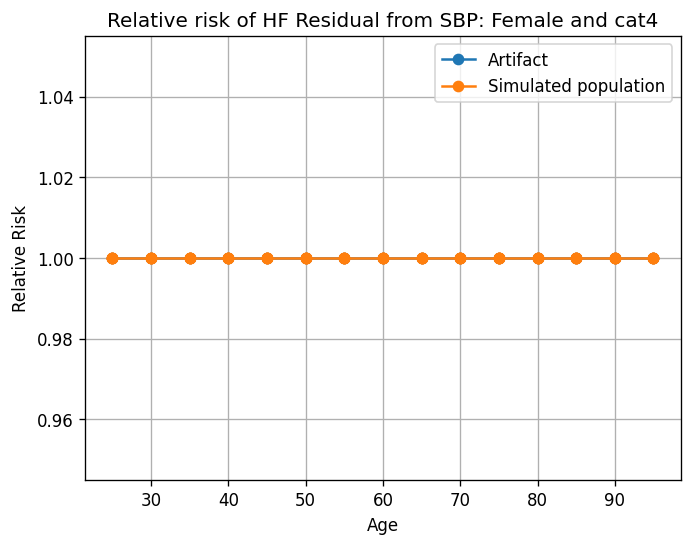

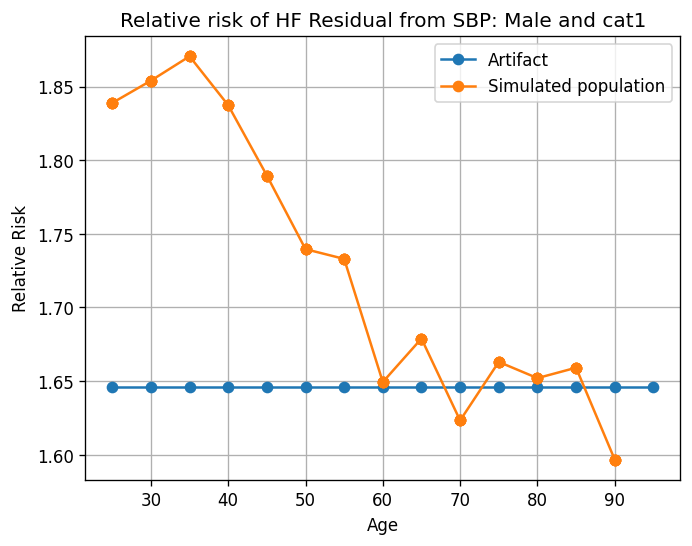

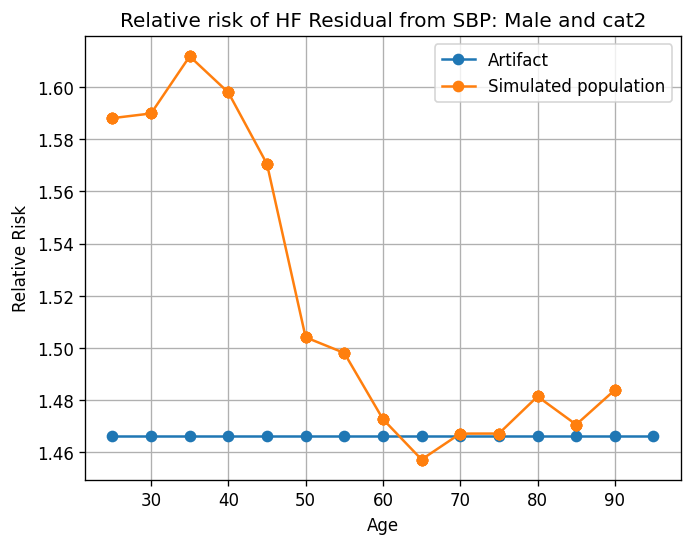

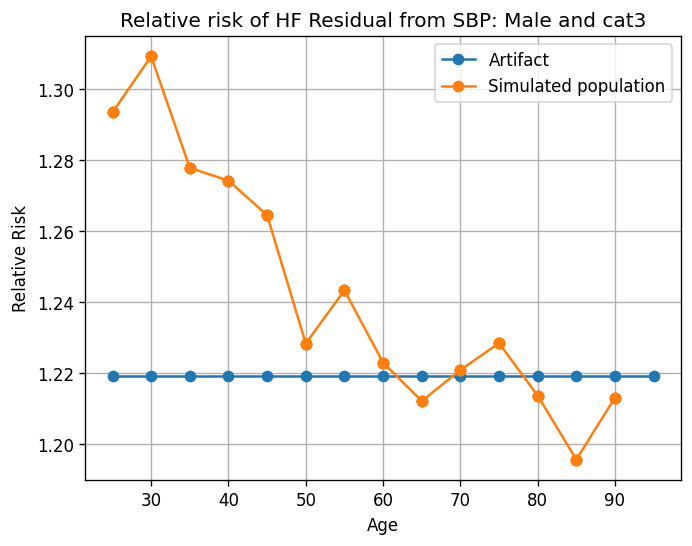

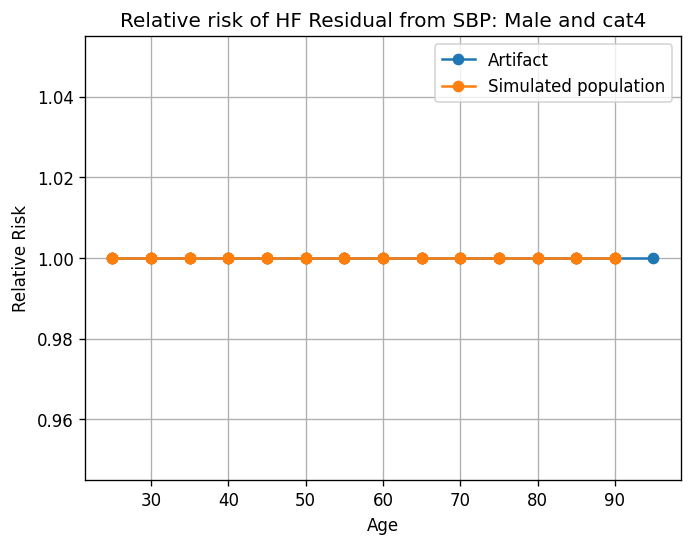

In [60]:
with PdfPages('hf_resid_sbp_rr.pdf') as pdf:
    for sex in df.sex.unique():
        for cat in df.Category.unique():
            plt.figure(dpi=120)
            subdata = hf_rr.loc[(hf_rr['sex']==sex) & (hf_rr['parameter']==cat)]
            plt.plot(subdata.age_start, subdata['mean'], marker='o', label='Artifact')
            subdata2 = df.loc[(df['sex']==sex) & (df['Category']==cat)]
            plt.plot(subdata2.age, subdata2.RR, marker='o', label='Simulated population')
            plt.title(f'Relative risk of HF Residual from SBP: {sex} and {cat}') 
            plt.ylabel('Relative Risk')
            plt.xlabel('Age')
            plt.legend()
            plt.grid()
            pdf.savefig(bbox_inches='tight')

# Alternative Method Which Includes Multiple Risks Simultaneously 

This is a bit confusing but we basically calculate what each simulant's incidence should be based on their exposures, PAFs, and RR's. Then we compare that to the artifact. 

In [61]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

51-locations/                       alaska.hdf        rhode_island.hdf
alabama.hdf                         north_dakota.hdf  washington.hdf
alabama_before_calculated_pafs.hdf  raw_data/         west_virginia.hdf


In [62]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [63]:
def load_artifact_key(word:str, cause:str, measure:str):
    data = pd.DataFrame()
    for i in ['alabama']:
        
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25', 'draw==0']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        data = art.load(word + '.' + cause + '.' + measure)
    return data

## Myocardial Infarction

In [64]:
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data_MI = data1[['age_start','sex','high_ldl','high_sbp','high_bmi','high_fpg','acute_myocardial_infarction_event_count']]
data_MI['acute_MI_binary'] = np.where(data_MI['acute_myocardial_infarction_event_count'] == 0, 0, 1)
data_MI = data_MI.loc[data_MI['age_start'] > 20]
data_MI.head()

,age_start,sex,high_ldl,high_sbp,high_bmi,high_fpg,acute_myocardial_infarction_event_count,acute_MI_binary
0,45.0,Female,2.125019,138.926833,23.052512,7.655254,0,0
1,40.0,Male,2.397553,137.634343,23.897422,9.447039,0,0
2,50.0,Female,2.110561,139.700114,22.755900,8.609653,0,0
3,30.0,Male,2.133673,127.697819,23.783141,8.511144,0,0
6,25.0,Male,3.286407,129.540010,36.145501,5.442680,0,0


In [65]:
## Load in all of the artifact data we will need

In [66]:
art_MI_inc = load_artifact_key('cause', 'myocardial_infarction', 'incidence_rate')
art_MI_inc = art_MI_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_MI_inc.head()

,sex,age_start,age_end,year_start,year_end,inc
0,Female,25.0,30.0,2019,2020,0.000403
1,Female,30.0,35.0,2019,2020,0.000430
2,Female,35.0,40.0,2019,2020,0.000355
3,Female,40.0,45.0,2019,2020,0.000450
4,Female,45.0,50.0,2019,2020,0.000717


In [67]:
art_MI_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_MI_rr_ldl = art_MI_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_MI_rr_ldl = art_MI_rr_ldl.loc[art_MI_rr_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_ldl.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_ldl
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0053
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0267
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0483
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.9898
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.8515


In [68]:
art_MI_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_MI_rr_sbp = art_MI_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_MI_rr_sbp = art_MI_rr_sbp.loc[art_MI_rr_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_sbp.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_sbp
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.0317
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.8558
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.6799
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.5729
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.5348


In [69]:
art_MI_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_MI_rr_bmi = art_MI_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_MI_rr_bmi = art_MI_rr_bmi.loc[art_MI_rr_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_bmi.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_bmi
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,3.510608
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,2.094858
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.685112
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.665879
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.591258


In [70]:
art_MI_rr_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'relative_risk')
art_MI_rr_fpg = art_MI_rr_fpg.rename(columns={"draw_0": "rr_fpg"}).reset_index()
art_MI_rr_fpg = art_MI_rr_fpg.loc[art_MI_rr_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_fpg.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,rr_fpg
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.9325
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.6915
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.4505
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.3135
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,per unit,1.2805


In [71]:
art_MI_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_MI_paf_ldl = art_MI_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_MI_paf_ldl = art_MI_paf_ldl.loc[art_MI_paf_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_ldl.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_ldl
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.703067
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.707316
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.705092
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.685767
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.658356


In [72]:
art_MI_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_MI_paf_sbp = art_MI_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_MI_paf_sbp = art_MI_paf_sbp.loc[art_MI_paf_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_sbp.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_sbp
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.479086
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.399835
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.448564
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.360870
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.464980


In [73]:
art_MI_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_MI_paf_bmi = art_MI_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_MI_paf_bmi = art_MI_paf_bmi.loc[art_MI_paf_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_bmi.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_bmi
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.976086
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.811838
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.778104
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.680518
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.657915


In [74]:
art_MI_paf_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')
art_MI_paf_fpg = art_MI_paf_fpg.rename(columns={"draw_0": "paf_fpg"}).reset_index()
art_MI_paf_fpg = art_MI_paf_fpg.loc[art_MI_paf_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_fpg.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,paf_fpg
0,Female,25.0,30.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.410015
1,Female,30.0,35.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.301534
2,Female,35.0,40.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.221111
3,Female,40.0,45.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.184682
4,Female,45.0,50.0,2019,2020,acute_myocardial_infarction,incidence_rate,0.164129


In [75]:
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==493]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_sbp,age_start,sex
0,55,10,1,2.0317,25,Male
1,56,11,1,1.8558,30,Male
2,57,12,1,1.6799,35,Male
3,58,13,1,1.5729,40,Male
4,59,14,1,1.5348,45,Male


In [76]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==493]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_ldl,age_start,sex
0,0,10,1,2.0053,25,Male
1,1,11,1,2.0267,30,Male
2,2,12,1,2.0483,35,Male
3,3,13,1,1.9898,40,Male
4,4,14,1,1.8515,45,Male


In [77]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==493]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_bmi,age_start,sex
0,135,14,2,1.591258,45,Female
1,136,17,2,1.379902,60,Female
2,137,12,2,1.685112,35,Female
3,138,13,2,1.665879,40,Female
4,139,20,2,1.291149,75,Female


In [78]:
rrs_fpg = get_draws(gbd_id_type='rei_id',
               gbd_id=105,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_fpg = rrs_fpg.loc[rrs_fpg.cause_id==493]
rrs_fpg = rrs_fpg[['age_group_id','sex_id','draw_0']]
rrs_fpg['age_start'] = np.where(rrs_fpg['age_group_id']==10,25,np.where(rrs_fpg['age_group_id']==11,30,np.where(rrs_fpg['age_group_id']==12,35,np.where(rrs_fpg['age_group_id']==13,40,np.where(rrs_fpg['age_group_id']==14,45,np.where(rrs_fpg['age_group_id']==15,50,np.where(rrs_fpg['age_group_id']==16,55,np.where(rrs_fpg['age_group_id']==17,60,np.where(rrs_fpg['age_group_id']==18,65,np.where(rrs_fpg['age_group_id']==19,70,np.where(rrs_fpg['age_group_id']==20,75,np.where(rrs_fpg['age_group_id']==30,80,np.where(rrs_fpg['age_group_id']==31,85,np.where(rrs_fpg['age_group_id']==32,90,0))))))))))))))
rrs_fpg['sex'] = np.where(rrs_fpg['sex_id']==1,'Male','Female')
rrs_fpg = rrs_fpg.rename(columns={"draw_0": "rr_gbd_fpg"}).reset_index()
rrs_fpg.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/get_draws/transforms/version_transforms.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[version_id_type_name] = version_id


,index,age_group_id,sex_id,rr_gbd_fpg,age_start,sex
0,0,10,2,1.9325,25,Female
1,1,11,2,1.6915,30,Female
2,2,12,2,1.4505,35,Female
3,3,13,2,1.3135,40,Female
4,4,14,2,1.2805,45,Female


In [79]:
## Merging everything together 
## This is a bit confusing but we basically calculate what each simulant's incidence should be based on their 
## exposures, PAFs, and RR's. Then we compare that to the artifact. 

tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

data_merged = (data_MI.merge(art_MI_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_MI_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_MI_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_MI_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
               .merge(art_MI_paf_fpg[['age_start','sex','paf_fpg']], on=['age_start','sex'])
              .merge(art_MI_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_MI_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_MI_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(art_MI_rr_fpg[['age_start','sex','rr_fpg']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_fpg[['age_start','sex','rr_gbd_fpg']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl < 1, 0, (data_merged.high_ldl - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['exposure_i_fpg'] = np.where(data_merged.high_fpg < tmrel_fpg, 0, (data_merged.high_fpg - tmrel_fpg))
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['rr_i_fpg'] = np.exp(np.log(data_merged.rr_gbd_fpg) * data_merged.exposure_i_fpg)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged['inc_i_fpg'] = data_merged.inc * (1 - data_merged.paf_fpg) * data_merged.rr_i_fpg
data_merged.head()

,age_start,sex,high_ldl,high_sbp,high_bmi,high_fpg,acute_myocardial_infarction_event_count,acute_MI_binary,inc,paf_ldl,...,exposure_i_bmi,exposure_i_fpg,rr_i_ldl,rr_i_sbp,rr_i_bmi,rr_i_fpg,inc_i_ldl,inc_i_sbp,inc_i_bmi,inc_i_fpg
0,45.0,Female,2.125019,138.926833,23.052512,7.655254,0,0,0.000717,0.658356,...,0.110502,2.555254,1.99972,3.102245,1.052671,1.880971,0.00049,0.00119,0.000258,0.001128
1,45.0,Female,2.125019,138.926833,23.052512,7.655254,0,0,0.000717,0.658356,...,0.110502,2.555254,1.99972,3.102245,1.052671,1.880971,0.00049,0.00119,0.000258,0.001128
2,45.0,Female,2.125019,138.926833,23.052512,7.655254,0,0,0.000717,0.658356,...,0.110502,2.555254,1.99972,3.102245,1.052671,1.880971,0.00049,0.00119,0.000258,0.001128
3,45.0,Female,2.125019,138.926833,23.052512,7.655254,0,0,0.000717,0.658356,...,0.110502,2.555254,1.99972,3.102245,1.052671,1.880971,0.00049,0.00119,0.000258,0.001128
4,45.0,Female,2.125019,138.926833,23.052512,7.655254,0,0,0.000717,0.658356,...,0.110502,2.555254,1.99972,3.102245,1.052671,1.880971,0.00049,0.00119,0.000258,0.001128


In [80]:
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi','inc_i_fpg']].reset_index()

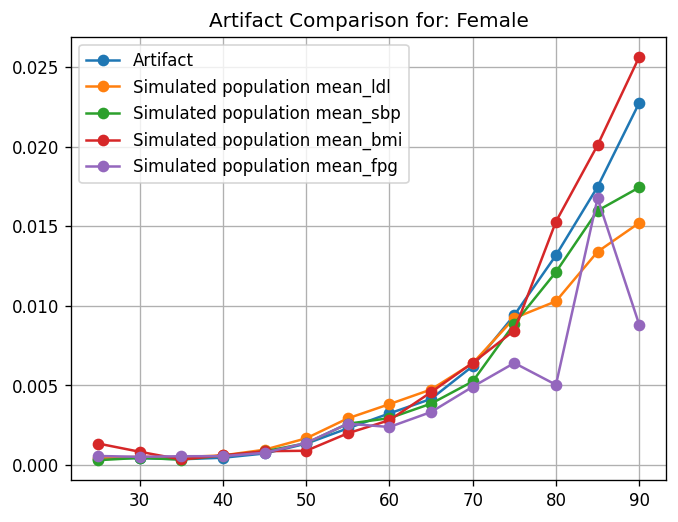

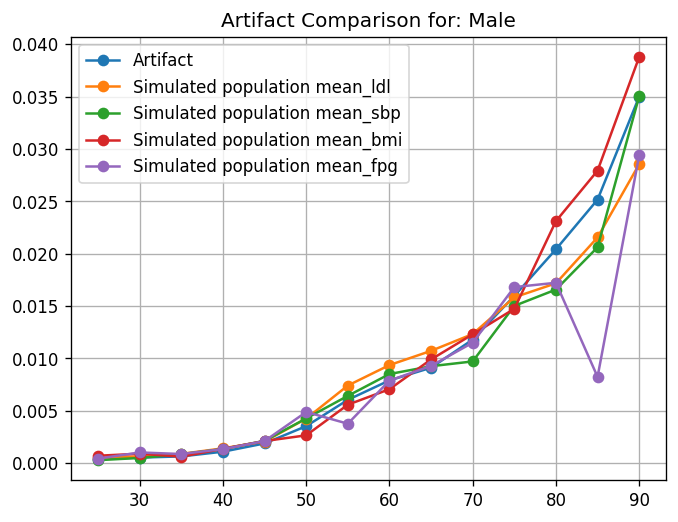

In [81]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.plot(subdata.age_start, subdata.inc_i_fpg, marker='o', label='Simulated population mean_fpg')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()